# Importing the Core Libraries for Start 

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

# All outputs are visible
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Retina resolution for the plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# All plots contained in the notebook
%matplotlib inline

## File Information

* train.csv : the training set describing which tracks are included in the playlists
* tracks.csv : supplementary information about tracks
* target_playlists.csv : the set of target playlists that will receive recommendations

### Target Playlists
* playlist_id : identifier of the playlist that will receive recommendations. The file contains a list of 10k playlists.

* The first 5k target playlists (from playlist_id=7 to playlist_id=50431) are sequential. For each of these playlists, the order of tracks in train.csv corresponds to the order inside the playlist.

* The last 5k target playlists (from playlist_id=3 to playlist_id=50424) are random. For each of these playlists, the order of tracks in train.csv is random and does not generally corresponds to the order inside the playlist. The same is for all other playlists in train.csv.

### Import the Files to the Notebook

In [102]:

trainData = pd.read_csv("../data/raw/train.csv")
trackData = pd.read_csv("../data/raw/tracks.csv")
tP = pd.read_csv("../data/raw/target_playlists.csv")
sS = pd.read_csv("../data/raw/sample_submission.csv")


In [103]:
def getSongs(data,p_id):
    return np.array(data[data['playlist_id'] == p_id]['track_id'])

### General info about the Train data

In [104]:
trainData.shape
trainData.head()
trainData.dtypes

(1211791, 2)

,playlist_id,track_id
0,0,14301
1,0,8360
2,0,12844
3,0,18397
4,0,1220


playlist_id    int64
track_id       int64
dtype: object

### General info about the Track data

In [105]:
trackData.shape
trackData.head()
trackData.dtypes

(20635, 4)

,track_id,album_id,artist_id,duration_sec
0,0,6306,449,167
1,1,12085,4903,185
2,2,1885,6358,201
3,3,3989,1150,263
4,4,11633,4447,96


track_id        int64
album_id        int64
artist_id       int64
duration_sec    int64
dtype: object

In [44]:
def count_rows(row):
    return row.value_counts

In [117]:
test = trackData['album_id'].value_counts().reset_index().rename(columns={"index":"album_id","album_id":"album_counts"})

test2 = trackData['artist_id'].value_counts().reset_index().rename(columns={"index":"artist_id","artist_id":"artist_counts"})

albums_songs = test.sort_values('album_counts',ascending=False)
artists_songs = test2.sort_values('artist_counts',ascending=False)
albums_songs.head()
artists_songs.head()

,album_id,album_counts
0,6622,28
1,4853,26
2,11633,24
3,4774,21
8,1490,16


,artist_id,artist_counts
0,2175,84
1,5367,67
2,3829,64
3,4782,61
4,6591,57


In [84]:
# Find how many songs each album contains

trackData['album_counts'] = trackData.groupby('album_id')['album_id'].transform(pd.Series.value_counts)
dfAlbum = pd.DataFrame(data=trackData.loc[:,['album_id','album_counts']])
dfAlbum = dfAlbum.sort_values('album_counts',ascending=False)


# Unique Album List
albumUnique = dfAlbum.drop_duplicates(subset='album_id').reset_index().rename(columns={'index':'track_id'})

# Number of Unique Albums
numAlbums = len(albumUnique)

# Find how many songs each artist has
trackData['artist_counts'] =trackData.groupby('artist_id')['artist_id'].transform(pd.Series.value_counts)
dfArtist = pd.DataFrame(data=trackData.loc[:,['artist_id','artist_counts']])
dfArtist = dfArtist.sort_values('artist_counts',ascending=False)
# Unique Artist List
artistUnique = dfArtist.drop_duplicates(subset='artist_id').reset_index().rename(columns={'index':'track_id'})
# Number of Unique Artists
numArtists = len(artistUnique)

ValueError: Length of passed values is 1, index implies 2

In [ ]:
print("Number of unique albums: {0}".format(numAlbums))
print("Number of unique artists: {0}".format(numArtists))
print("Album with the most number of songs is: {0} with {1} songs".format(albumUnique.loc[0,'album_id'],albumUnique.loc[0,'album_counts']))
print("Artist with the most number of songs is: {0} with {1} songs".format(artistUnique.loc[0,'artist_id'],artistUnique.loc[0,'artist_counts']))

In [35]:
# Find how many users(Playlists) are there
trainData['track_count'] = trainData.groupby('playlist_id')['playlist_id'].transform(pd.Series.value_counts)
dfPlaylist = pd.DataFrame(data=trainData.loc[:,['playlist_id','track_count']])
dfPlaylist = dfPlaylist.sort_values('track_count',ascending=False)
playlists = dfPlaylist.drop_duplicates(subset='playlist_id').reset_index().rename(columns={'index':'interaction_id'})


ValueError: Length of passed values is 1, index implies 5

In [ ]:
playlists.head()
playlists.shape

In [10]:
tracks = trackData['track_id'].values.reshape(len(trackData['track_id']),1)
playlists2 = playlists['playlist_id'].values.reshape(len(playlists['playlist_id']),1)
tracks.shape
tracks

NameError: name 'playlists' is not defined

In [11]:
playlists.shape
playlists.head()

NameError: name 'playlists' is not defined

In [12]:
 row = np.zeros((20635,1),dtype=int)

songCount = np.array(trainData[trainData['playlist_id'] == 6602]['track_id'])
row[songCount] = 1
playlistRatings = pd.DataFrame(data=np.zeros((playlists['playlist_id'].shape[0],tracks.shape[0])))
for playlist_id in playlists['playlist_id']:
    songCount = np.array(trainData[trainData['playlist_id'] == playlist_id]['track_id'])
    playlistRatings.loc[playlist_id,:][songCount] = 1
    


NameError: name 'playlists' is not defined

In [13]:
playlistRatings.mean(axis=1)

NameError: name 'playlistRatings' is not defined

In [14]:
plr2 = pd.DataFrame(data=np.zeros((playlists['playlist_id'].shape[0],tracks.shape[0])))
plr2.loc[playlists['playlist_id'],:][np.array(trainData[trainData['playlist_id'] == playlist_id]['track_id'])] = 1

NameError: name 'playlists' is not defined

In [15]:
playlistColumn = pd.DataFrame(data=trainData['playlist_id'])
trackColumn = pd.DataFrame(data=trainData['track_id'])
# User Equivalent
numPlaylist = len(playlists['playlist_id'])
# Item Equivalent
numTrack = len(trackData['track_id'])
numInteractions = len(trainData)

print ("Number of items\t {}, Number of users\t {}".format(numTrack,numPlaylist))
print ("Average interactions per user {:.2f}".format(numInteractions/numPlaylist))
print ("Average interactions per item {:.2f}\n".format(numInteractions/numTrack))

print ("Sparsity {:.2f} %".format((1-float(numInteractions)/(numTrack*numPlaylist))*100))

NameError: name 'playlists' is not defined

In [16]:
trainData['rating'] = list(zip(trainData['playlist_id'],trainData['track_id']))

### General info about the Target Playlists

Seperating the sequential and random ordered playlists

In [ ]:
tPSeq = tP.iloc[0:5000]
tPRand = tP.iloc[5000:]

### Seperate the columns of the interactions as Tuples

In [17]:
interactionColumn = np.array(trainData['track_id'])
playlistColumn =  np.array(playlistColumn).flatten()
trackColumn = np.array(trackColumn).flatten()

In [18]:
import scipy.sparse as sps
URM_all = sps.coo_matrix((interactionColumn,(playlistColumn,trackColumn)))
URM_all

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 1211791 stored elements in COOrdinate format>

In [19]:
URM_all.tocsr()

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 1211791 stored elements in Compressed Sparse Row format>

In [20]:
itemPopularity = (URM_all>0).sum(axis=0)
itemPopularity = np.array(itemPopularity).squeeze()
itemPopularity.shape

(20635,)

In [21]:
itemPopularity = np.sort(itemPopularity)
itemPopularity

array([   0,    1,    1, ..., 1666, 1725, 1785], dtype=int64)

Text(0, 0.5, 'Num Interactions ')

Text(0.5, 0, 'User Index')

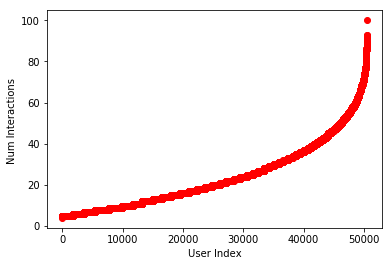

In [22]:
userActivity = (URM_all>0).sum(axis=1)
userActivity = np.array(userActivity).squeeze()
userActivity = np.sort(userActivity)


plt.plot(userActivity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('User Index')
plt.show()

In [23]:
train_test_split = 0.80
numInteractions = URM_all.nnz
train_mask = np.random.choice([True,False], numInteractions, p=[train_test_split, 1-train_test_split])
train_mask

URM_train = sps.coo_matrix((interactionColumn[train_mask], (playlistColumn[train_mask], trackColumn[train_mask])))
URM_train = URM_train.tocsr()
URM_train

array([ True,  True,  True, ...,  True,  True, False])

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 970153 stored elements in Compressed Sparse Row format>

In [24]:
test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((interactionColumn[test_mask], (playlistColumn[test_mask], trackColumn[test_mask])))
URM_test = URM_test.tocsr()
URM_test

<50446x20634 sparse matrix of type '<class 'numpy.int64'>'
	with 241638 stored elements in Compressed Sparse Row format>

In [25]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        itemPopularity = (URM_train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popularItems[0:at]

        return recommended_items


In [26]:
def precision(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True) 
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant) 
    return precision_score

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True) 
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]  
    return recall_score

def MAP(recommended_items, relevant_items): 
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True) 
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))  
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])
    return map_score

In [27]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for playlist_id in playlists2:

        relevant_items = URM_test[playlist_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(playlist_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 



In [28]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

In [29]:
for user_id in playlists2[0:10]:
    print(topPopRecommender.recommend(user_id, at=10))

NameError: name 'playlists2' is not defined

In [30]:
evaluate_algorithm(URM_test, topPopRecommender, at=10)

NameError: name 'playlists2' is not defined

In [ ]:
class TopPopRecommender2(object):

    def fit(self, URM_train): 
        self.URM_train = URM_train
        itemPopularity = (URM_train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()
        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    def recommend(self, user_id, at=10, remove_seen=True):
        if remove_seen:
            unseen_items_mask = np.in1d(self.popularItems, self.URM_train[playlist_id].indices,
                                        assume_unique=True, invert = True)
            unseen_items = self.popularItems[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.popularItems[0:at]
            
        return str(recommended_items).strip("[]")

In [ ]:
topPopRecommender_removeSeen = TopPopRecommender2()
topPopRecommender_removeSeen.fit(URM_train)

for playlist_id in tP['playlist_id'][0:10]:
    print(topPopRecommender_removeSeen.recommend(playlist_id, at=10))

In [ ]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen,at=10)

In [ ]:
f= open("submission2.csv","w+")
f.write("playlist_id,track_ids\n")
for ind,playlist_id in enumerate(tP['playlist_id']):
    f.write(str(playlist_id) + ','+ topPopRecommender_removeSeen.recommend(playlist_id,at=10) + '\n');
f.close();

In [ ]:
globalAverage = np.mean(URM_train.data)

print("The global average is {:.2f}".format(globalAverage))

In [ ]:
URM_train_unbiased = URM_train.copy()
URM_train_unbiased.data -= globalAverage
print(URM_train_unbiased.data[0:10])

In [ ]:
item_mean_rating = URM_train_unbiased.mean(axis=0)
item_mean_rating

In [ ]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating!=0])

plt.plot(item_mean_rating, 'ro')
plt.ylabel('Item Bias')
plt.xlabel('Item Index')
plt.show()

In [ ]:
user_mean_rating = URM_train_unbiased.mean(axis=1)
user_mean_rating

In [ ]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

plt.plot(user_mean_rating, 'ro')
plt.ylabel('User Bias')
plt.xlabel('User Index')
plt.show()

In [ ]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train):  
        self.URM_train = URM_train
        globalAverage = np.mean(URM_train.data)
        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= int(globalAverage)
        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()
        self.bestRatedItems = np.argsort(item_mean_rating)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)

        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            unseen_items_mask = np.in1d(self.bestRatedItems, URM_train[playlist_id].indices,
                                        assume_unique=True, invert = True)
            unseen_items = self.bestRatedItems[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.bestRatedItems[0:at]

        return str(recommended_items).strip("[]")

In [ ]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

In [ ]:
f= open("submission3.csv","w+")
f.write("playlist_id,track_ids\n")
for ind,playlist_id in enumerate(tP['playlist_id']):
    f.write(str(playlist_id) + ','+ GlobalEffectsRecommender.recommend(playlist_id,at=10) + '\n');
f.close();